# 가위바위보 분류기

## 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


<br>

## 데이터 준비
- google teachable machine 사이트에서 제작
  - https://teachablemachine.withgoogle.com/
  - `Get Started` > `Image Project - Standard image model` > 웹캠을 이용해 이미지 데이터 촬영 가능
  - `<Hold to Record>` 버튼으로 캡쳐

<br>

- 참고) 디렉토리 만들기

```
$ mkdir -p ~/aiffel/rock_scissor_paper/scissor
$ mkdir -p ~/aiffel/rock_scissor_paper/rock
$ mkdir -p ~/aiffel/rock_scissor_paper/paper
$ ls -l ~/aiffel/rock_scissor_paper
```

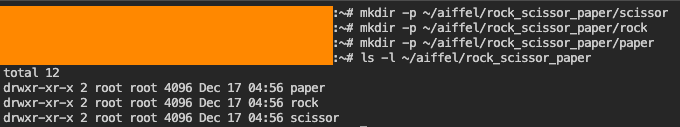

### 가위 이미지 데이터 100개
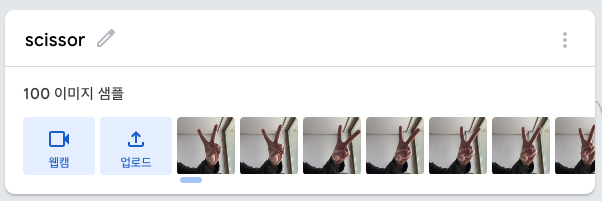


<br>

### 바위 이미지 데이터 100개
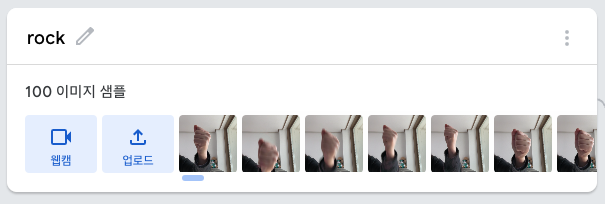


<br>

### 보 이미지 데이터 100개
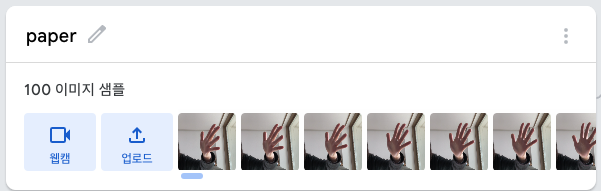


<br>

### 이미지 업로드
- Cloud Jupyter에서 진행
- `rock_scissor_paper/rock` 디렉토리로 이동하여 `Upload` 버튼 클릭
  - rock, paper도 동일하게 진행
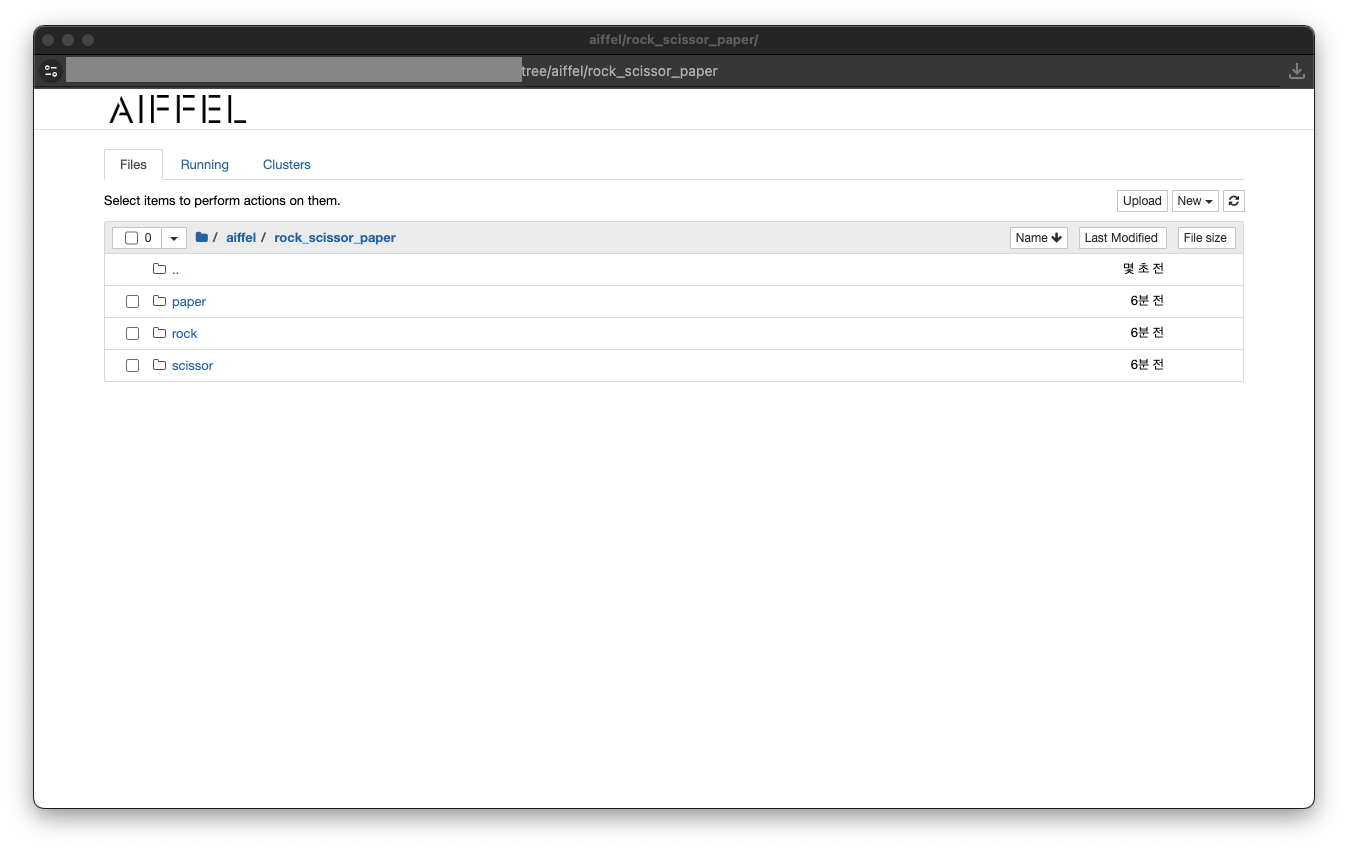
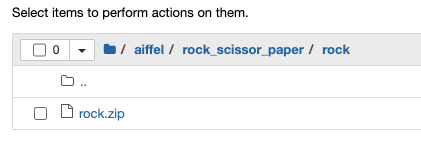
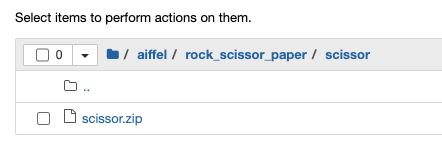
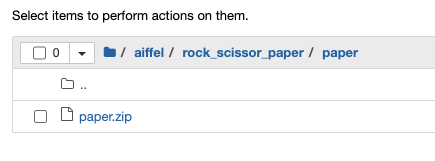

<br>

- 참고) 디렉토리 구조
```
aiffel
└── rock_scissor_paper
    ├── rock
        └── rock.zip
    ├── scissor
        └── scissor.zip
    └── paper
        └── paper.zip
```

### 이미지 압축 해제
- Cloud shell에서 진행

```
# 원하는 디렉토리로 이동
$ cd  ~/aiffel/rock_scissor_paper/rock

# 압축 해제 명령어 : unzip <파일명>.zip
$ unzip rock.zip

# 가위, 보에 대해서도 똑같이 실행!
$ cd  ~/aiffel/rock_scissor_paper/scissor
$ unzip scissor.zip

$ cd  ~/aiffel/rock_scissor_paper/paper
$ unzip paper.zip
```

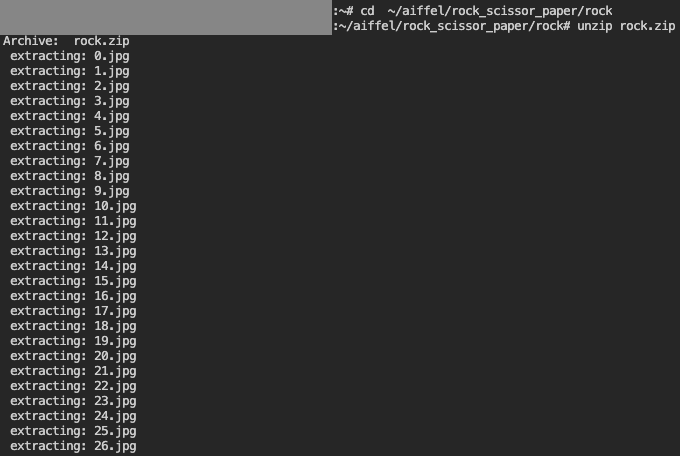
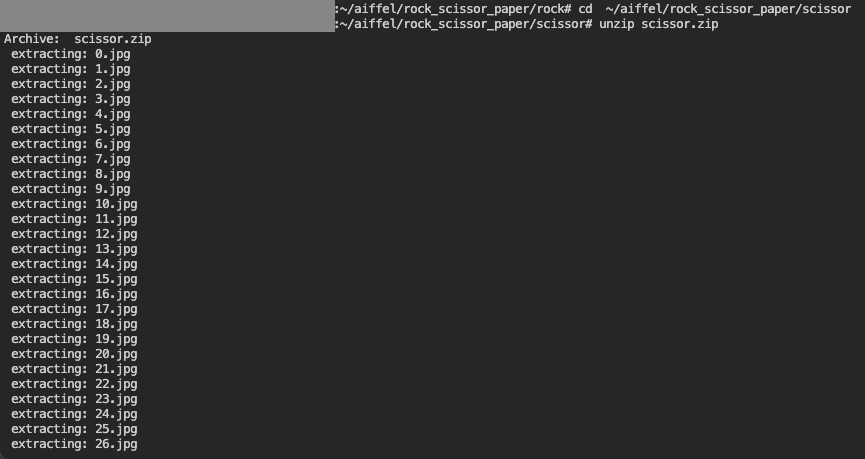
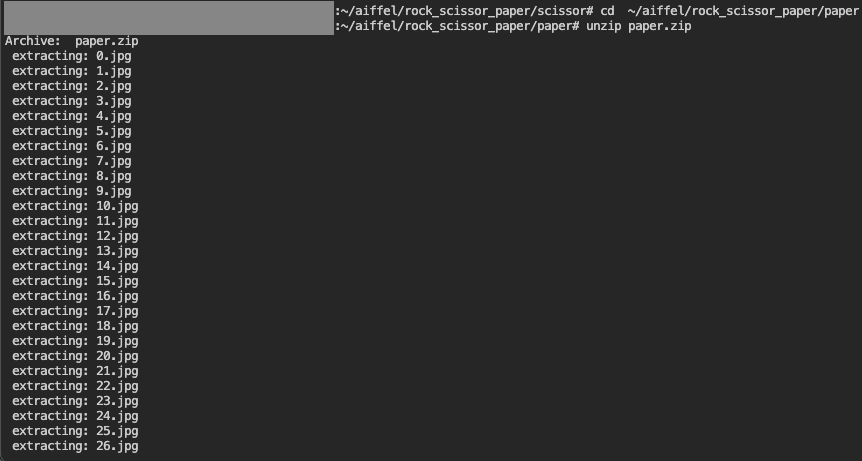

> 다운로드 받은 이미지 크기
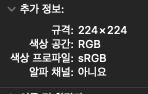

<br>

## 데이터셋 로드 & Resize
- 28x28로 resize하기
  - PIL 라이브러리 사용

In [3]:
from PIL import Image 
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


### 가위 이미지

In [4]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")   
    print(len(images), " images to be resized.")

    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    print(len(images), " images resized.")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


### 바위 이미지

In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


### 보자기 이미지

In [6]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 이미지 resize 완료!


<br>

## `load_data()` 함수로 가위, 바위, 보 데이터 읽어오기
- 클래스 3개로 정리
  - 가위 : 0
  - 바위 : 1
  - 보 : 2

In [7]:
import numpy as np

def load_data(img_path, number_of_data=300): # 데이터 실제 총합으로 진행
    img_size=28
    color=3
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    
    # 가위
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    # 바위
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1  
    
    # 보
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수:", idx)
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)

# 입력 정규화(0~1)
x_train_norm = x_train/255.0

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수: 300
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


- 이미지 불러오기

label:  0


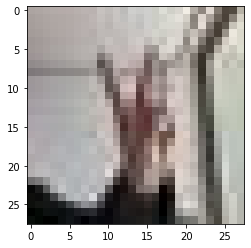

In [8]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('label: ', y_train[0])

<br>

## 딥러닝 네트워크 설계 & 학습

### 시도 1
- n_channel_1 = 16
- n_channel_2 = 32
- n_dense = 32
- n_train_epoch = 10

In [52]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# n_channel_1 = 16
# n_channel_2 = 32
# n_dense = 32
# n_train_epoch = 10

n_channel_1 = 32
n_channel_2 = 64
n_dense = 128
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

### 딥러닝 네트워크 학습

Epoch 1/20
10/10 [==============================] - 1s 37ms/step - loss: 64.5930 - accuracy: 0.3367
Epoch 2/20
10/10 [==============================] - 0s 37ms/step - loss: 5.2769 - accuracy: 0.4000
Epoch 3/20
10/10 [==============================] - 0s 38ms/step - loss: 0.6923 - accuracy: 0.7867
Epoch 4/20
10/10 [==============================] - 0s 37ms/step - loss: 0.2089 - accuracy: 0.9333
Epoch 5/20
10/10 [==============================] - 0s 39ms/step - loss: 0.0715 - accuracy: 0.9800
Epoch 6/20
10/10 [==============================] - 0s 39ms/step - loss: 0.0219 - accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 0s 37ms/step - loss: 0.0138 - accuracy: 0.9967
Epoch 8/20
10/10 [==============================] - 0s 36ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 0s 38ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 11

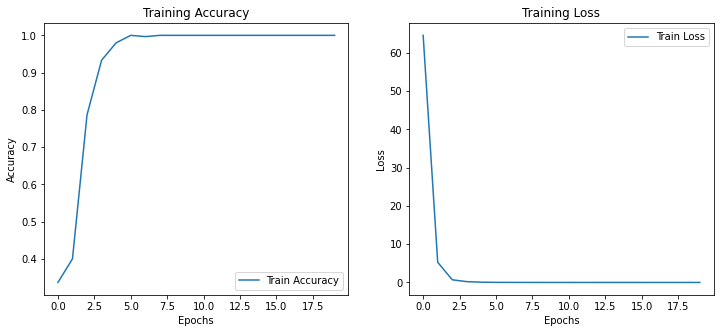

In [53]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

<br>

### 시도 2 -> 이전 시도에서 1.0이 나왔기 때문에 실행하지 않음
- n_channel_1: 32
- n_channel_2: 64
- n_dense: 128
- n_train_epoch: 15

In [ ]:
# n_channel_1 = 32
# n_channel_2 = 64
# n_dense = 128
# n_train_epoch = 15

# model = keras.models.Sequential()
# model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
# model.add(keras.layers.MaxPool2D(2,2))
# model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(n_dense, activation='relu'))
# model.add(keras.layers.Dense(3, activation='softmax'))

# model.summary()

<br>

## 테스트 데이터로 확인
- test 디렉토리 생성 & 데이터 업로드
```
$ mkdir -p ~/aiffel/rock_scissor_paper/test
```

++ unzip 진행하고 할 것

In [54]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

for category in categories:
    resize_images(f"{base_path}/{category}")

(x_test, y_test) = load_data(base_path)
x_test_norm = x_test / 255.0

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


#### 모델 학습

10/10 - 0s - loss: 2.9322 - accuracy: 0.3500
test_loss: 2.932157516479492 
test_accuracy: 0.3499999940395355


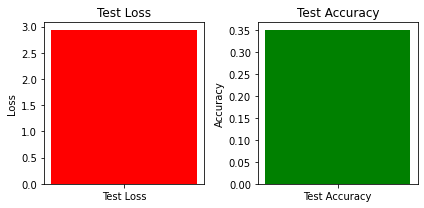

In [55]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

def plot_test_results(test_loss, test_accuracy):
    plt.figure(figsize=(6, 3))

    # test loss
    plt.subplot(1, 2, 1)
    plt.bar(['Test Loss'], [test_loss], color='r')
    plt.title('Test Loss')
    plt.ylabel('Loss')

    # test accuracy
    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy], color='g')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

plot_test_results(test_loss, test_accuracy)

<br>

## 성능이 아주 낮게 측정됨
- 다른 시도가 필요함

---

<br>

## train 데이터셋 증강

In [57]:
import glob
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(img_path, number_of_data=300):  # 데이터 실제 총합으로 진행
    img_size = 28
    color = 3
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0

    # 가위
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 0
        idx = idx + 1

    # 바위
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 1
        idx = idx + 1

    # 보
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 2
        idx = idx + 1

    print("학습데이터(x_train)의 이미지 개수:", idx)
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path)

x_train_norm = x_train / 255.0

# 훈련 데이터에 대한 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,          # 랜덤 회전
    width_shift_range=0.2,      # 가로 이동
    height_shift_range=0.2,     # 세로 이동
    shear_range=0.2,            # 전단 변환
    zoom_range=0.2,             # 확대/축소
    horizontal_flip=True,       # 수평 뒤집기
    fill_mode='nearest'         # 픽셀 보간 방식
)

datagen.fit(x_train_norm)

for x_batch, y_batch in datagen.flow(x_train_norm, y_train, batch_size=32):
    print(f"x_batch shape: {x_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    break

# 모델 학습
model.fit(datagen.flow(x_train_norm, y_train, batch_size=32), epochs=50)

학습데이터(x_train)의 이미지 개수: 300
x_batch shape: (32, 28, 28, 3)
y_batch shape: (32,)
Epoch 1/50
10/10 [==============================] - 1s 53ms/step - loss: 1.0979 - accuracy: 0.3733
Epoch 2/50
10/10 [==============================] - 1s 52ms/step - loss: 1.0969 - accuracy: 0.3767
Epoch 3/50
10/10 [==============================] - 1s 52ms/step - loss: 1.0956 - accuracy: 0.4000
Epoch 4/50
10/10 [==============================] - 1s 51ms/step - loss: 1.0956 - accuracy: 0.3700
Epoch 5/50
10/10 [==============================] - 1s 52ms/step - loss: 1.0956 - accuracy: 0.3433
Epoch 6/50
10/10 [==============================] - 1s 51ms/step - loss: 1.0916 - accuracy: 0.3533
Epoch 7/50
10/10 [==============================] - 1s 52ms/step - loss: 1.0905 - accuracy: 0.3767
Epoch 8/50
10/10 [==============================] - 1s 53ms/step - loss: 1.0879 - accuracy: 0.3667
Epoch 9/50
10/10 [==============================] - 1s 53ms/step - loss: 1.0807 - accuracy: 0.4333
Epoch 10/50
10/10 [==========

### test 데이터로 재확인

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
10/10 - 0s - loss: 1.0513 - accuracy: 0.2567
test_loss: 1.0513
test_accuracy: 0.2567


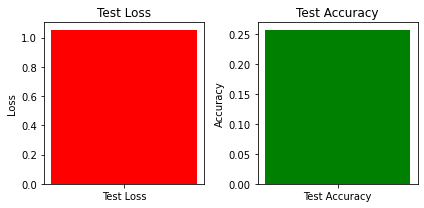

In [60]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 이미지를 크기 조정하는 함수 호출 (resize_images는 사용자 정의 함수)
for category in categories:
    resize_images(f"{base_path}/{category}")

# 테스트 데이터 로드
(x_test, y_test) = load_data(base_path)
x_test_norm = x_test / 255.0  # 정규화

# 테스트 데이터 형태 출력
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# 모델 성능 평가 (정규화된 데이터로 평가)
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

# 평가 결과 출력
print("test_loss: {:.4f}".format(test_loss))
print("test_accuracy: {:.4f}".format(test_accuracy))

# 테스트 결과를 시각화하는 함수
def plot_test_results(test_loss, test_accuracy):
    plt.figure(figsize=(6, 3))

    # 테스트 손실 (loss)
    plt.subplot(1, 2, 1)
    plt.bar(['Test Loss'], [test_loss], color='r')
    plt.title('Test Loss')
    plt.ylabel('Loss')

    # 테스트 정확도 (accuracy)
    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy], color='g')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# 테스트 손실과 정확도 시각화
plot_test_results(test_loss, test_accuracy)

<br>

## 과하게 증강되지 않도록 재설정

In [61]:
import glob
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(img_path, number_of_data=300):  # 데이터 실제 총합으로 진행
    img_size = 28
    color = 3
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype=np.int32)

    idx = 0

    # 가위
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 0
        idx = idx + 1

    # 바위
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 1
        idx = idx + 1

    # 보
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 2
        idx = idx + 1

    print("학습데이터(x_train)의 이미지 개수:", idx)
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path)

x_train_norm = x_train / 255.0

# 훈련 데이터에 대한 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train_norm)

for x_batch, y_batch in datagen.flow(x_train_norm, y_train, batch_size=32):
    print(f"x_batch shape: {x_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    break

# 모델 학습
model.fit(datagen.flow(x_train_norm, y_train, batch_size=32), epochs=50)

학습데이터(x_train)의 이미지 개수: 300
x_batch shape: (32, 28, 28, 3)
y_batch shape: (32,)
Epoch 1/50
10/10 [==============================] - 1s 52ms/step - loss: 0.3066 - accuracy: 0.9267
Epoch 2/50
10/10 [==============================] - 1s 50ms/step - loss: 0.2677 - accuracy: 0.9400
Epoch 3/50
10/10 [==============================] - 1s 53ms/step - loss: 0.2334 - accuracy: 0.9567
Epoch 4/50
10/10 [==============================] - 1s 54ms/step - loss: 0.2258 - accuracy: 0.9500
Epoch 5/50
10/10 [==============================] - 1s 53ms/step - loss: 0.1914 - accuracy: 0.9567
Epoch 6/50
10/10 [==============================] - 1s 51ms/step - loss: 0.2092 - accuracy: 0.9500
Epoch 7/50
10/10 [==============================] - 1s 50ms/step - loss: 0.1873 - accuracy: 0.9667
Epoch 8/50
10/10 [==============================] - 1s 53ms/step - loss: 0.1979 - accuracy: 0.9533
Epoch 9/50
10/10 [==============================] - 1s 53ms/step - loss: 0.1776 - accuracy: 0.9600
Epoch 10/50
10/10 [==========

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
10/10 - 0s - loss: 1.9325 - accuracy: 0.2567
test_loss: 1.9325
test_accuracy: 0.2567


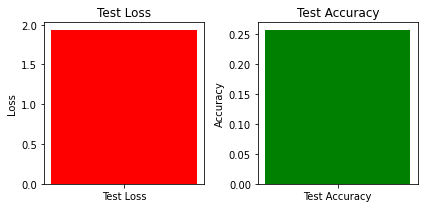

In [62]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

for category in categories:
    resize_images(f"{base_path}/{category}")

(x_test, y_test) = load_data(base_path)
x_test_norm = x_test / 255.0  # 정규화

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

print("test_loss: {:.4f}".format(test_loss))
print("test_accuracy: {:.4f}".format(test_accuracy))

def plot_test_results(test_loss, test_accuracy):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.bar(['Test Loss'], [test_loss], color='r')
    plt.title('Test Loss')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy], color='g')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

plot_test_results(test_loss, test_accuracy)

- 오히려 성능이 낮게 측정됨

<br>

## 모델 세부 사항 변경 시도

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 128)        

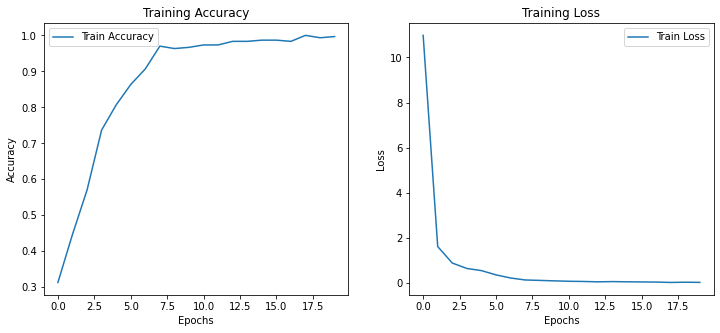

In [65]:
import tensorflow as tf
from tensorflow import keras

n_channel_1 = 32
n_channel_2 = 64
n_channel_3 = 128  # Conv 레이어 추가
n_dense = 128
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Conv2D(n_channel_2, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Conv2D(n_channel_3, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Dropout(dropout_rate))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(n_dense, activation='relu'))

model.add(keras.layers.Dense(3, activation='softmax'))


model.summary()


model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
10/10 - 0s - loss: 1.0984 - accuracy: 0.3233
test_loss: 1.0984
test_accuracy: 0.3233


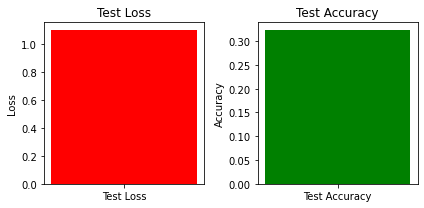

In [66]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

for category in categories:
    resize_images(f"{base_path}/{category}")

(x_test, y_test) = load_data(base_path)
x_test_norm = x_test / 255.0  # 정규화

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

print("test_loss: {:.4f}".format(test_loss))
print("test_accuracy: {:.4f}".format(test_accuracy))

def plot_test_results(test_loss, test_accuracy):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.bar(['Test Loss'], [test_loss], color='r')
    plt.title('Test Loss')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy], color='g')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

plot_test_results(test_loss, test_accuracy)

<br>
<br>

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 128)        

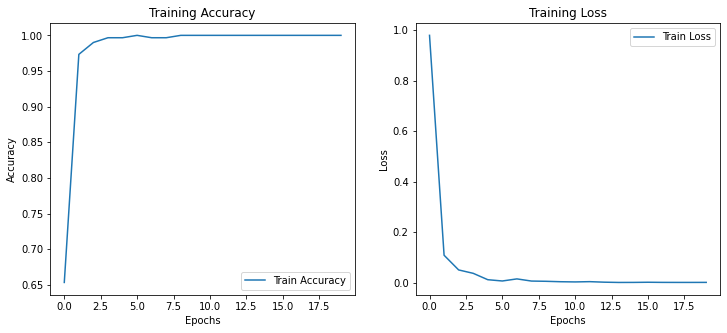

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

n_channel_1 = 32
n_channel_2 = 64
n_channel_3 = 128
n_dense = 128
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

model = keras.models.Sequential()

model.add(layers.Conv2D(n_channel_1, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(n_channel_2, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(n_channel_3, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Dropout(dropout_rate))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(n_dense, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
10/10 - 0s - loss: 3.0121 - accuracy: 0.3333
test_loss: 3.0121
test_accuracy: 0.3333


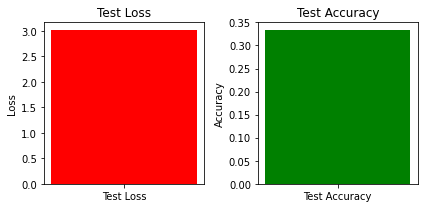

In [68]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

for category in categories:
    resize_images(f"{base_path}/{category}")

(x_test, y_test) = load_data(base_path)
x_test_norm = x_test / 255.0  # 정규화

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)

print("test_loss: {:.4f}".format(test_loss))
print("test_accuracy: {:.4f}".format(test_accuracy))

def plot_test_results(test_loss, test_accuracy):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.bar(['Test Loss'], [test_loss], color='r')
    plt.title('Test Loss')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.bar(['Test Accuracy'], [test_accuracy], color='g')
    plt.title('Test Accuracy')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

plot_test_results(test_loss, test_accuracy)

### 튜닝 시도

In [69]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 KB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.4/597.4 KB 22.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.2 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.0 requires typing

In [71]:
import optuna
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def objective(trial):
    model = keras.Sequential()

    conv_1_filters = trial.suggest_int('conv_1_filters', 16, 64, step=16)
    conv_2_filters = trial.suggest_int('conv_2_filters', 32, 128, step=32)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model.add(layers.Conv2D(conv_1_filters, (3, 3), activation='relu', input_shape=(28,28,3)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(conv_2_filters, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    x_train_norm = x_train / 255.0
    history = model.fit(x_train_norm, y_train, epochs=10, validation_split=0.2, verbose=0)

    # 최적화 목표: validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters: ", study.best_params)

# 최적 하이퍼파라미터 적용
best_params = study.best_params
model = keras.Sequential()
model.add(layers.Conv2D(best_params['conv_1_filters'], (3, 3), activation='relu', input_shape=(28,28,3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(best_params['conv_2_filters'], (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(best_params['dense_units'], activation='relu'))
model.add(layers.Dropout(rate=best_params['dropout_rate']))
model.add(layers.Dense(3, activation='softmax'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

x_train_norm = x_train / 255.0
model.fit(x_train_norm, y_train, epochs=10, validation_split=0.2)

x_test_norm = x_test / 255.0
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

[I 2024-12-17 07:34:36,555] A new study created in memory with name: no-name-43ffd940-3f9b-4856-bce9-b8bb4bd54438
/tmp/ipykernel_31/4230351549.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-12-17 07:34:41,161] Trial 0 finished with value: 1.0 and parameters: {'conv_1_filters': 48, 'conv_2_filters': 64, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001962354757965976}. Best is trial 0 with value: 1.0.
[I 2024-12-17 07:34:45,683] Trial 1 finished with value: 0.1666666716337204 and parameters: {'conv_1_filters': 16, 'conv_2_filters': 128, 'dense_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.00013269535984306334}. Best is trial 0 with value: 1.0.
[I 2024-12-17 07:34:50,097] Trial 2 finished with value: 1.0 and parameters: {'conv_

Best hyperparameters:  {'conv_1_filters': 48, 'conv_2_filters': 64, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001962354757965976}
Epoch 1/10
8/8 [==============================] - 1s 69ms/step - loss: 1.0393 - accuracy: 0.4792 - val_loss: 2.0039 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 55ms/step - loss: 0.8954 - accuracy: 0.5917 - val_loss: 1.5713 - val_accuracy: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 0s 55ms/step - loss: 0.7731 - accuracy: 0.6625 - val_loss: 1.1337 - val_accuracy: 0.3333
Epoch 4/10
8/8 [==============================] - 0s 58ms/step - loss: 0.4607 - accuracy: 0.8708 - val_loss: 0.6495 - val_accuracy: 0.7833
Epoch 5/10
8/8 [==============================] - 0s 55ms/step - loss: 0.2647 - accuracy: 0.8958 - val_loss: 0.4131 - val_accuracy: 0.8500
Epoch 6/10
8/8 [==============================] - 0s 53ms/step - loss: 0.1866 - accuracy: 0.9333 - val_loss: 0.1155 - val_accuracy: 1.0000
Epoch 7/10


<br>

## Test 데이터 추가
- 동균님 데이터에 + 용재님 데이터 추가

In [72]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (600, 28, 28, 3)
y_test_combined shape: (600,)
19/19 - 0s - loss: 3.3630 - accuracy: 0.3700
Test loss: 3.3630
Test accuracy: 0.3700


In [73]:
import optuna
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def objective(trial):
    model = keras.Sequential()

    conv_1_filters = trial.suggest_int('conv_1_filters', 16, 64, step=16)
    conv_2_filters = trial.suggest_int('conv_2_filters', 32, 128, step=32)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model.add(layers.Conv2D(conv_1_filters, (3, 3), activation='relu', input_shape=(28,28,3)))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Conv2D(conv_2_filters, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    x_train_norm = x_train / 255.0
    history = model.fit(x_train_norm, y_train, epochs=10, validation_split=0.2, verbose=0)

    # 최적화 목표: validation accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters: ", study.best_params)

# 최적 하이퍼파라미터 적용
best_params = study.best_params
model = keras.Sequential()
model.add(layers.Conv2D(best_params['conv_1_filters'], (3, 3), activation='relu', input_shape=(28,28,3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(best_params['conv_2_filters'], (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(best_params['dense_units'], activation='relu'))
model.add(layers.Dropout(rate=best_params['dropout_rate']))
model.add(layers.Dense(3, activation='softmax'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

x_train_norm = x_train / 255.0
model.fit(x_train_norm, y_train, epochs=10, validation_split=0.2)

x_test_norm = x_test / 255.0
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

[I 2024-12-17 07:51:17,007] A new study created in memory with name: no-name-ed5c73b4-abf9-4bb7-8b26-d86cb4f895ae
/tmp/ipykernel_31/3840622218.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-12-17 07:51:20,110] Trial 0 finished with value: 0.9666666388511658 and parameters: {'conv_1_filters': 16, 'conv_2_filters': 64, 'dense_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.001984159226323132}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-12-17 07:51:25,122] Trial 1 finished with value: 0.9666666388511658 and parameters: {'conv_1_filters': 64, 'conv_2_filters': 32, 'dense_units': 128, 'dropout_rate': 0.6, 'learning_rate': 0.0008126229730885144}. Best is trial 0 with value: 0.9666666388511658.
[I 2024-12-17 07:51:30,408] Trial 2 fini

Best hyperparameters:  {'conv_1_filters': 64, 'conv_2_filters': 32, 'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.008711466491952168}
Epoch 1/10
8/8 [==============================] - 1s 73ms/step - loss: 1.1623 - accuracy: 0.4583 - val_loss: 1.5821 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 0s 57ms/step - loss: 0.9535 - accuracy: 0.5833 - val_loss: 1.1797 - val_accuracy: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 0s 57ms/step - loss: 0.7157 - accuracy: 0.7125 - val_loss: 1.5618 - val_accuracy: 0.0000e+00
Epoch 4/10
8/8 [==============================] - 0s 56ms/step - loss: 0.5190 - accuracy: 0.8167 - val_loss: 0.3599 - val_accuracy: 0.8500
Epoch 5/10
8/8 [==============================] - 0s 57ms/step - loss: 0.2842 - accuracy: 0.9000 - val_loss: 0.6918 - val_accuracy: 0.6167
Epoch 6/10
8/8 [==============================] - 0s 57ms/step - loss: 0.1053 - accuracy: 0.9625 - val_loss: 0.3138 - val_accuracy: 0.8833
Epoch 

<br>

### 모델에 Dense 층 추가

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_147 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_147 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_71 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_144 (Dense)            (None, 256)               409856    
_________________________________________________________________
dense_145 (Dense)            (None, 3)               

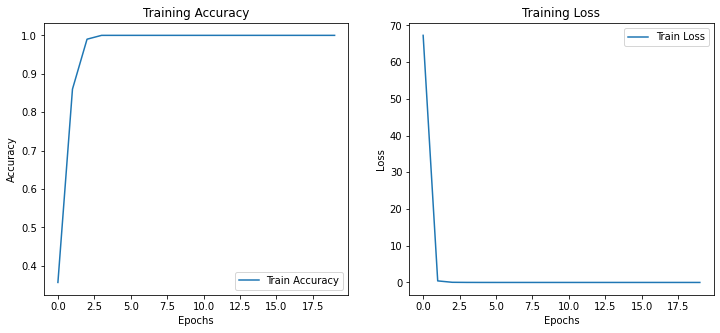

In [75]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# n_channel_1 = 16
# n_channel_2 = 32
# n_dense = 32
# n_train_epoch = 10

n_channel_1 = 32
n_channel_2 = 64
n_dense = 256
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [76]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (600, 28, 28, 3)
y_test_combined shape: (600,)
19/19 - 0s - loss: 1.0969 - accuracy: 0.3333
Test loss: 1.0969
Test accuracy: 0.3333


<br>

### 데이터 추가
- 3명 데이터를 모두 합쳐서 재평가해보기

In [77]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (900, 28, 28, 3)
y_test_combined shape: (900,)
29/29 - 0s - loss: 1.0812 - accuracy: 0.5556
Test loss: 1.0812
Test accuracy: 0.5556


### n_dense 조정

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_157 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_76 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_156 (Dense)            (None, 64)                102464    
_________________________________________________________________
dense_157 (Dense)            (None, 3)               

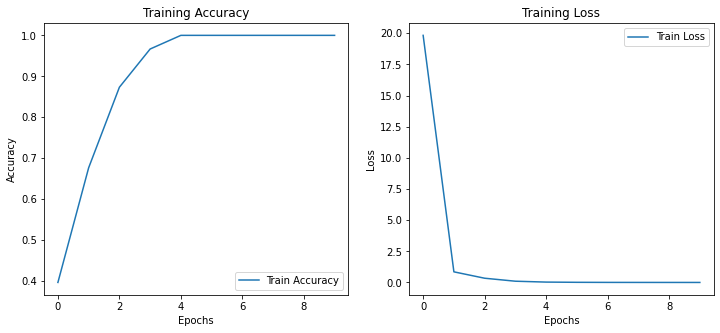

In [86]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 10
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [87]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (900, 28, 28, 3)
y_test_combined shape: (900,)
29/29 - 0s - loss: 1.0887 - accuracy: 0.5556
Test loss: 1.0886847972869873
Test accuracy: 0.5555555820465088


<br>

### dropout으로 오버피팅 줄이기 시도
- 0.1

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_177 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_177 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_86 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_176 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)              

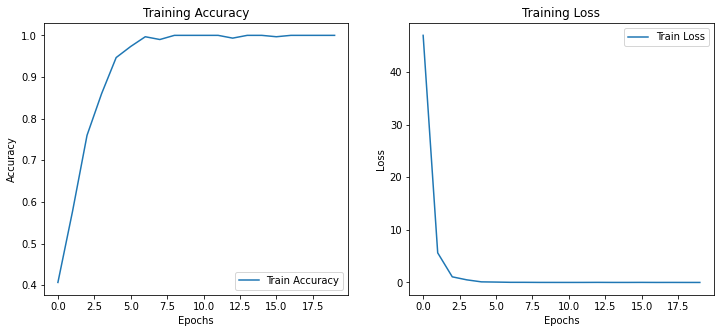

In [104]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.1

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [105]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (900, 28, 28, 3)
y_test_combined shape: (900,)
29/29 - 0s - loss: 1.0868 - accuracy: 0.6089
Test loss: 1.0868369340896606
Test accuracy: 0.6088888645172119


<br>

- 0.08

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_183 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_183 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_89 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_182 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_79 (Dropout)         (None, 64)              

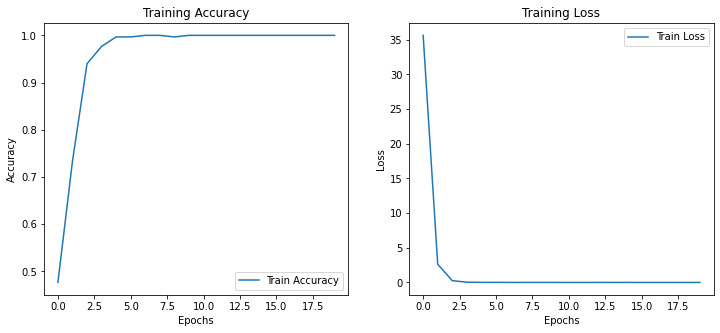

In [110]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.08

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [111]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (900, 28, 28, 3)
y_test_combined shape: (900,)
29/29 - 0s - loss: 1.0788 - accuracy: 0.6122
Test loss: 1.0788480043411255
Test accuracy: 0.6122221946716309


- 0.09

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_197 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_197 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_198 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_96 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_196 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_86 (Dropout)         (None, 64)              

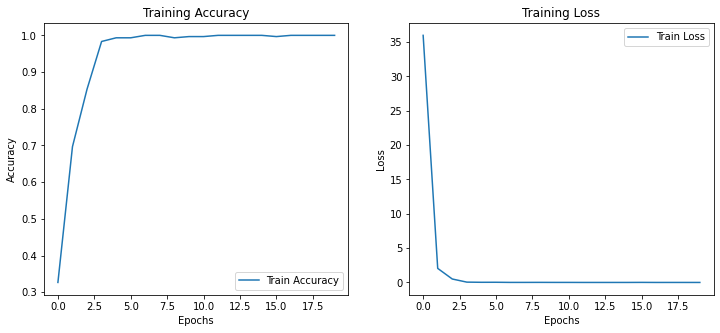

In [122]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.09

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [123]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (900, 28, 28, 3)
y_test_combined shape: (900,)
29/29 - 0s - loss: 1.0859 - accuracy: 0.6167
Test loss: 1.0858911275863647
Test accuracy: 0.6166666746139526


<br>
<br>

# test 데이터 추가하기
- 방법1 : 내가 test 데이터 더 만들어서 추가해보기
- 방법2 : 다른 분들 test 데이터 더 받아서 추가해보기

#### 방법 1 수행해보기_Test, Test2, Test3, Test4

In [124]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"


for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1200, 28, 28, 3)
y_test_combined shape: (1200,)
38/38 - 0s - loss: 1.0802 - accuracy: 0.7125
Test loss: 1.0802165269851685
Test accuracy: 0.7124999761581421


- 파라미터 세부 조정
  - 0.09

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_227 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_227 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_228 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_228 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_111 (Flatten)        (None, 1600)              0         
_________________________________________________________________
dense_226 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_101 (Dropout)        (None, 64)             

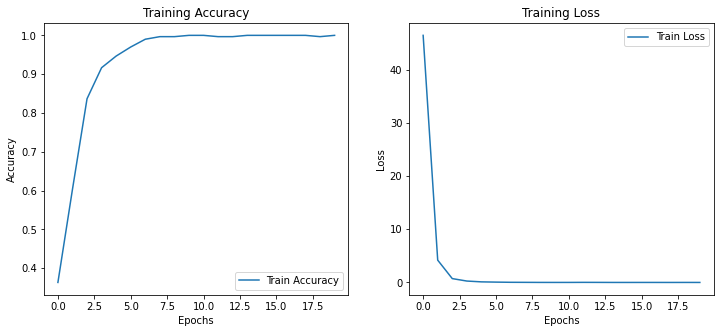

In [149]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.09

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [150]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"


for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3), axis=0)

# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1200, 28, 28, 3)
y_test_combined shape: (1200,)
38/38 - 1s - loss: 1.0799 - accuracy: 0.7167
Test loss: 1.0798975229263306
Test accuracy: 0.7166666388511658


---

In [152]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path4)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1500, 28, 28, 3)
y_test_combined shape: (1500,)
47/47 - 0s - loss: 1.0766 - accuracy: 0.7733
Test loss: 1.0765810012

- test4를 중복 사용(실수에서 나왔지만, 값이 높게 측정됨..)

In [168]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path3)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1500, 28, 28, 3)
y_test_combined shape: (1500,)
47/47 - 1s - loss: 1.0809 - accuracy: 0.7460
Test loss: 1.0809394121

- test3, test4를 중복 사용하여 테스트

In [177]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path2)
(x_test_additional5, y_test_additional5) = load_data(additional_data_path3)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4, x_test_additional5), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4, y_test_additional5), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1800, 28, 28, 3)
y_test_combined shape: (1800,)
57/57 - 1s - loss: 1.0791 - accuracy: 0.

In [253]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path2)
(x_test_additional5, y_test_additional5) = load_data(additional_data_path3)
(x_test_additional6, y_test_additional6) = load_data(additional_data_path2)
(x_test_additional7, y_test_additional7) = load_data(additional_data_path3)


# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4, x_test_additional5, x_test_additional6, x_test_additional7), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4, y_test_additional5, y_test_additional6, y_test_additional7), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (2400, 28, 28, 3)
y_test_combined

---

### Test, Test2, Test3, Test4, Test5
- dropout_rate : 0.01

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_257 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_257 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_258 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_258 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_126 (Flatten)        (None, 1600)              0         
_________________________________________________________________
dense_256 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_116 (Dropout)        (None, 64)             

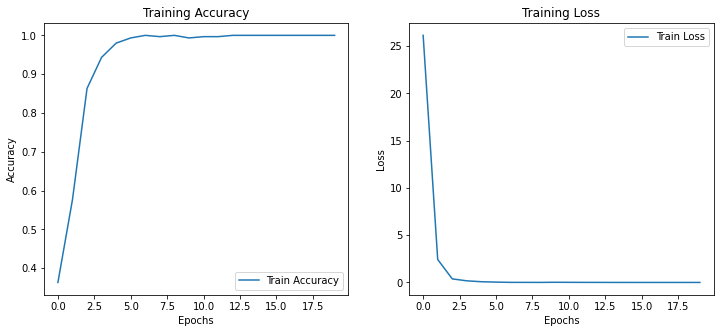

In [196]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.01

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [197]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path4)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1500, 28, 28, 3)
y_test_combined shape: (1500,)
47/47 - 1s - loss: 1.0861 - accuracy: 0.6447
Test loss: 1.0861321687

<br>

- dropout_rate : 0.02

Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_297 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_297 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_298 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_146 (Flatten)        (None, 1600)              0         
_________________________________________________________________
dense_296 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_136 (Dropout)        (None, 64)             

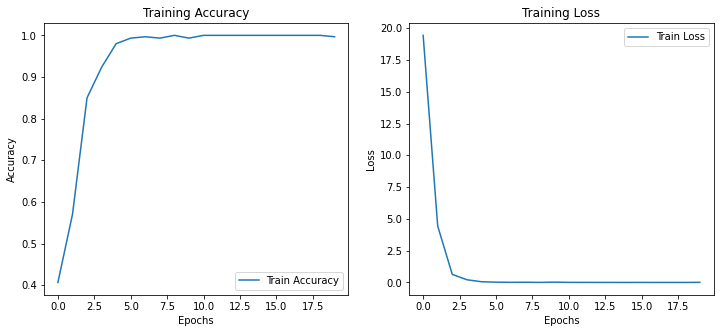

In [234]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.02

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [235]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path4)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1500, 28, 28, 3)
y_test_combined shape: (1500,)
47/47 - 1s - loss: 1.0842 - accuracy: 0.6080
Test loss: 1.0842014551

<br>

- dropout_rate : 0.03

Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_301 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_301 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_302 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_148 (Flatten)        (None, 1600)              0         
_________________________________________________________________
dense_300 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_138 (Dropout)        (None, 64)             

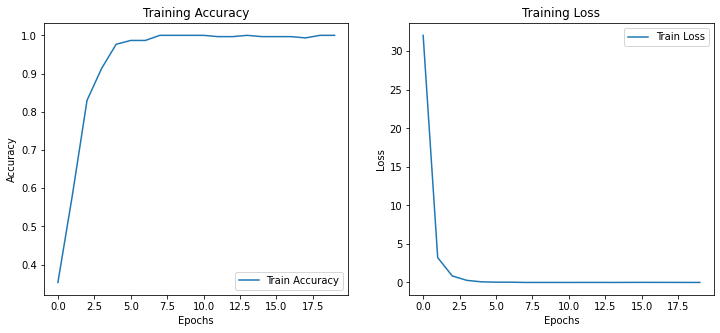

In [238]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.03

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [239]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path4)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1500, 28, 28, 3)
y_test_combined shape: (1500,)
47/47 - 1s - loss: 1.0815 - accuracy: 0.6167
Test loss: 1.0815032720

<br>

- dropout_rate : 0.09

Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_307 (Conv2D)          (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_307 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_308 (MaxPoolin (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_151 (Flatten)        (None, 1600)              0         
_________________________________________________________________
dense_306 (Dense)            (None, 64)                102464    
_________________________________________________________________
dropout_141 (Dropout)        (None, 64)             

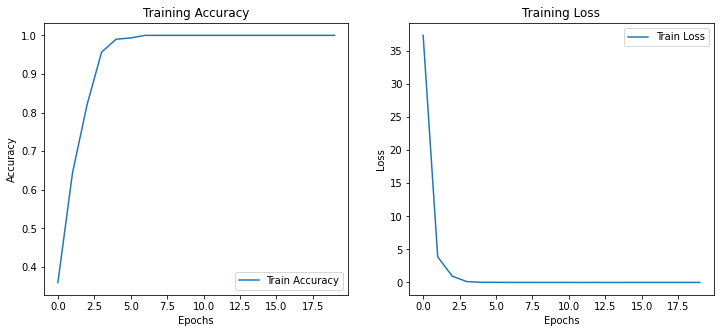

In [244]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 20
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.09

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=batch_size)

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [245]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path4)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
x_test_combined shape: (1500, 28, 28, 3)
y_test_combined shape: (1500,)
47/47 - 1s - loss: 1.0780 - accuracy: 0.6267
Test loss: 1.0780245065

<br>
<br>

### Test, Test2, Test3, Test4, Test5, Test6

In [252]:
categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test2"
additional_data_path2 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test3"
additional_data_path3 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test4"
additional_data_path4 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test5"
additional_data_path5 = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test6"

for category in categories:
    resize_images(f"{base_path}/{category}")
    resize_images(f"{additional_data_path}/{category}")
    resize_images(f"{additional_data_path2}/{category}")
    resize_images(f"{additional_data_path3}/{category}")
    resize_images(f"{additional_data_path4}/{category}")
    resize_images(f"{additional_data_path5}/{category}")

# 데이터 로드
(x_test, y_test) = load_data(base_path)
(x_test_additional, y_test_additional) = load_data(additional_data_path)
(x_test_additional2, y_test_additional2) = load_data(additional_data_path2)
(x_test_additional3, y_test_additional3) = load_data(additional_data_path3)
(x_test_additional4, y_test_additional4) = load_data(additional_data_path4)
(x_test_additional5, y_test_additional5) = load_data(additional_data_path5)

# 기존 데이터와 추가 데이터를 합침
x_test_combined = np.concatenate((x_test, x_test_additional, x_test_additional2, x_test_additional3, x_test_additional4, x_test_additional5), axis=0)
y_test_combined = np.concatenate((y_test, y_test_additional, y_test_additional2, y_test_additional3, y_test_additional4, y_test_additional5), axis=0)


# 정규화
x_test_combined_norm = x_test_combined / 255.0

print(f"x_test_combined shape: {x_test_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_combined_norm, y_test_combined, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 300
학습데이터(x_train)의 이미지 개수: 

#### 데이터 증강 적용

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

categories = ["scissor", "rock", "paper"]
base_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"

# 추가 데이터 경로
additional_data_paths = [
    os.getenv("HOME") + f"/aiffel/rock_scissor_paper/test{i}" for i in range(2, 7)
]

def augment_data(x_data, y_data):
    datagen = ImageDataGenerator(
        rotation_range=10,       # 이미지 회전
        width_shift_range=0.001,  # 수평 이동
        height_shift_range=0.001, # 수직 이동
        shear_range=0.001,        # 전단 변환
        zoom_range=0.001,         # 확대/축소
        horizontal_flip=False,   # 좌우 반전 사용 안함
        fill_mode='nearest'      # 빈 픽셀 채우기 방식
    )

    augmented_x = []
    augmented_y = []

    for x, y in zip(x_data, y_data):
        x = x.reshape((1, *x.shape))
        aug_iter = datagen.flow(x, [y], batch_size=1)
        for _ in range(10):
            aug_data, aug_label = next(aug_iter)
            augmented_x.append(aug_data[0])
            augmented_y.append(aug_label[0])
    
    return np.array(augmented_x), np.array(augmented_y)

def load_and_combine_data(paths):
    x_combined, y_combined = [], []
    for path in paths:
        x_data, y_data = load_data(path)
        x_combined.append(x_data)
        y_combined.append(y_data)
    return np.concatenate(x_combined, axis=0), np.concatenate(y_combined, axis=0)

all_paths = [base_path] + additional_data_paths
x_test_combined, y_test_combined = load_and_combine_data(all_paths)


x_augmented, y_augmented = augment_data(x_test_combined, y_test_combined)


x_final = np.concatenate((x_test_combined, x_augmented), axis=0)
y_final = np.concatenate((y_test_combined, y_augmented), axis=0)


x_final_norm = x_final / 255.0

print(f"x_final shape: {x_final.shape}")
print(f"y_final shape: {y_final.shape}")


test_loss, test_accuracy = model.evaluate(x_final_norm, y_final, verbose=2)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

NameError: name 'load_data' is not defined